<a href="https://colab.research.google.com/github/falseywinchnet/PyITD/blob/main/ITD_Based_MLP_KAN_hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext heat


In [15]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate multi-scale pattern data
def generate_data(n_samples=1000):
    X = np.linspace(0, 2 * np.pi, n_samples)

    # More complex slow-moving trend (sum of sinusoids with different frequencies)
    slow_trend = np.sin(2 * X) + 0.5 * np.tan(0.5 * X + np.pi / 4) + 0.5 * np.cos(0.7 * X + np.pi / 4)

    # Higher frequency oscillations with varying amplitudes
    fast_oscillations = 0.4 * np.sin(20 * X) + 0.2 * np.sin(30 * X + np.pi / 3)

    # More frequent and stronger spikes
    spikes = np.zeros_like(X)
    spike_indices = np.random.choice(n_samples, size=30, replace=False)  # Increased number of spikes
    spikes[spike_indices] = np.random.uniform(-2, 2, size=30)            # Stronger spikes

    # Increased noise level
    noise = 0.1 * np.random.randn(n_samples)

    # Combine all components
    y = slow_trend + fast_oscillations + spikes + noise

    return X.reshape(-1, 1), y.reshape(-1, 1)


import torch
import torch.nn as nn



class ITD_Linear(nn.Module):
    def __init__(self, input_length, input_dim, output_dim, use_bias=True):
        super(ITD_Linear, self).__init__()
        self.input_length = input_length
        self.output_dim = output_dim
        self.use_bias = use_bias

        if use_bias:
            self.bias = nn.Parameter(torch.zeros((output_dim, 1), dtype=torch.float32))
        else:
            self.register_parameter('bias', None)

        positions = torch.arange(input_length, dtype=torch.float32)
        self.register_buffer('positions', positions)

        # Store names of grid and basis buffers
        self.grid_names = []
        self.basis_names = []

        scales = torch.linspace(2, input_length // 2, output_dim)
        for grid_size in scales:
            grid_size_int = int(grid_size.item())
            indices = torch.linspace(0, input_length - 1, grid_size_int).long()

            grid_name = f'grid_{grid_size_int}'
            self.register_buffer(grid_name, indices)
            self.grid_names.append(grid_name)

            scale_factor = (grid_size_int - 1) / (input_length - 1)
            seg_idx = (positions * scale_factor).long().clamp(0, grid_size_int - 2)

            x_grid = indices.to(torch.float32)
            grid_start = x_grid[seg_idx]
            grid_end = x_grid[seg_idx + 1]
            delta = grid_end - grid_start + 1e-12  # avoid division by zero
            t = (positions - grid_start) / delta

            t2 = t * t
            t3 = t2 * t
            h00 = 2 * t3 - 3 * t2 + 1
            h10 = t3 - 2 * t2 + t
            h01 = -2 * t3 + 3 * t2
            h11 = t3 - t2

            basis = torch.stack([h00, h10, h01, h11], dim=0)  # shape: (4, input_length)
            basis_name = f'basis_{grid_size_int}'
            self.register_buffer(basis_name, basis)
            self.basis_names.append(basis_name)

    def forward(self, x):
        # x shape: (batch, input_length, input_dim) where input_dim==1 in our case.
        batch, L, _ = x.shape
        outputs = []
        for scale_idx, (grid_name, basis_name) in enumerate(zip(self.grid_names, self.basis_names)):
            grid = getattr(self, grid_name)
            basis = getattr(self, basis_name)
            grid_size_int = grid.shape[0]

            # Get grid values from the input signal
            ext_vals = x[:, grid, 0]  # (batch, grid_size_int)
            d = (ext_vals[:, 1:] - ext_vals[:, :-1]) / (grid[1:] - grid[:-1] + 1e-12)

            m = torch.zeros((batch, grid_size_int), device=x.device, dtype=x.dtype)
            m[:, [0, 1, -2, -1]] = d[:, [0, 0, -1, -1]]

            if grid_size_int > 3:
                i_range = torch.arange(2, grid_size_int - 2, device=x.device)
                d_im2 = d[:, i_range - 2]
                d_im1 = d[:, i_range - 1]
                d_i   = d[:, i_range]
                d_ip1 = d[:, i_range + 1]
                w1, w2 = (d_ip1 - d_i).abs(), (d_im1 - d_im2).abs()
                denom = w1 + w2 + 1e-12
                m[:, i_range] = torch.where(denom >= 1e-6,
                                            (w1 * d_im1 + w2 * d_i) / (denom + 1e-12),
                                            0.5 * (d_im1 + d_i))

            h00, h10, h01, h11 = basis

            scale_factor = (grid_size_int - 1) / (L - 1)
            seg_idx = (self.positions * scale_factor).long().clamp(0, grid_size_int - 2)
            seg_idx_exp = seg_idx.unsqueeze(0).expand(batch, -1)
            seg_idx_plus = (seg_idx + 1).unsqueeze(0).expand(batch, -1)

            y0 = torch.gather(ext_vals, 1, seg_idx_exp)
            y1 = torch.gather(ext_vals, 1, seg_idx_plus)
            m0 = torch.gather(m, 1, seg_idx_exp)
            m1 = torch.gather(m, 1, seg_idx_plus)
            delta = (grid[1] - grid[0]).unsqueeze(0).expand(batch, L)

            baseline = h00 * y0 + h10 * m0 * delta + h01 * y1 + h11 * m1 * delta
            if self.bias is not None:
                baseline += self.bias[scale_idx]

            outputs.append(baseline.unsqueeze(1))  # shape: (batch, 1, input_length)

        result = torch.cat(outputs, dim=1)  # shape: (batch, output_dim, input_length)
        return result



# Vanilla MLP operating on the entire signal.
# It flattens the input (batch, L, 1) into (batch, L) and maps it to (batch, L) before reshaping.
class VanillaMLP(nn.Module):
    def __init__(self, input_length, hidden_dim, output_length):
        super(VanillaMLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_length, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_length)
        )

    def forward(self, x):
        # x shape: (batch, L, 1) -> flatten to (batch, L)
        batch, L, _ = x.shape
        x_flat = x.view(batch, -1)
        out = self.fc(x_flat)
        # Reshape output to (batch, L, 1)
        return out.view(batch, L, 1)

# ITD-based MLP that uses the AcceleratedITDLayer.
# Note: It now takes an additional argument 'input_length' to know how many time steps to expect.
class ITDMLP(nn.Module):
    def __init__(self, input_length, hidden_dim, output_length):
        super(ITDMLP, self).__init__()
        # The ITD layer produces an output of shape (batch, hidden_dim, input_length)
        self.itd = ITD_Linear(input_length=input_length, input_dim=1, output_dim=hidden_dim)
        self.fc = nn.Sequential(
            nn.GELU(),
            nn.Linear(hidden_dim * input_length, output_length)
        )

    def forward(self, x):
        # x shape: (batch, L, 1)
        x_itd = self.itd(x)         # -> (batch, hidden_dim, L)
        x_flat = x_itd.view(x_itd.size(0), -1)  # -> (batch, hidden_dim * L)
        out = self.fc(x_flat)       # -> (batch, output_length)
        return out.view(x.size(0), -1, 1)  # reshape to (batch, L, 1)

# Training loop
def train(model, X_train, y_train, epochs=500, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        if loss.item() < 1e-12:
            print(f"Early stopping at epoch {epoch}")
            break
    return losses

# Main demo
# Get data and add a batch dimension (batch size = 1)
X, y = generate_data(n_samples=1000)
X_train = torch.tensor(X, dtype=torch.float32).unsqueeze(0)  # shape: (1, 1000, 1)
y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(0)  # shape: (1, 1000, 1)
input_length = X_train.shape[1]

# Initialize models
vanilla_mlp = VanillaMLP(input_length=input_length, hidden_dim=1, output_length=input_length)
itd_mlp = ITDMLP(input_length=input_length, hidden_dim=2, output_length=input_length)
dd =  itd_pred = itd_mlp(X_train)       # shape: (1000, 1)

# Train models


Training Vanilla MLP
Epoch 0, Loss: 498.3331
Epoch 50, Loss: 497.9911
Epoch 100, Loss: 497.6669
Epoch 150, Loss: 497.3491
Epoch 200, Loss: 497.0374
Epoch 250, Loss: 496.7312
Epoch 300, Loss: 496.4304
Epoch 350, Loss: 496.1345
Epoch 400, Loss: 495.8434
Epoch 450, Loss: 495.5568

Training ITD-based MLP
Epoch 0, Loss: 503.8596
Epoch 50, Loss: 118.3258
Epoch 100, Loss: 18.6354
Epoch 150, Loss: 1.2859
Epoch 200, Loss: 0.0309
Epoch 250, Loss: 0.0002
Epoch 300, Loss: 0.0000
Epoch 350, Loss: 0.0000
Epoch 400, Loss: 0.0000
Epoch 450, Loss: 0.0000


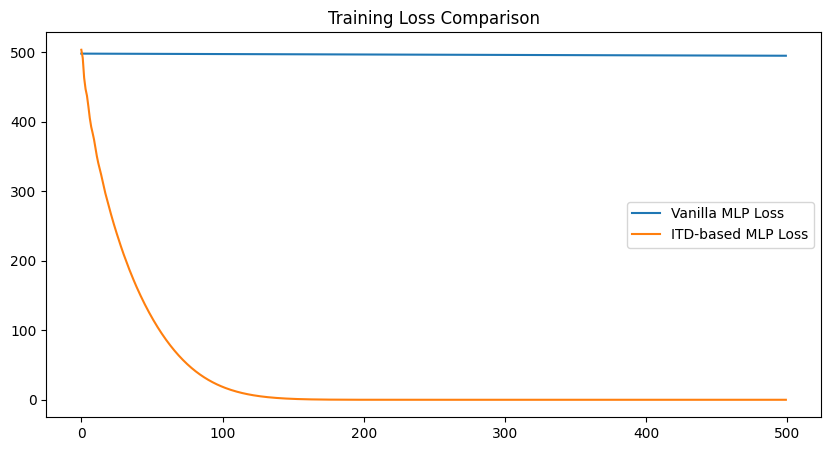

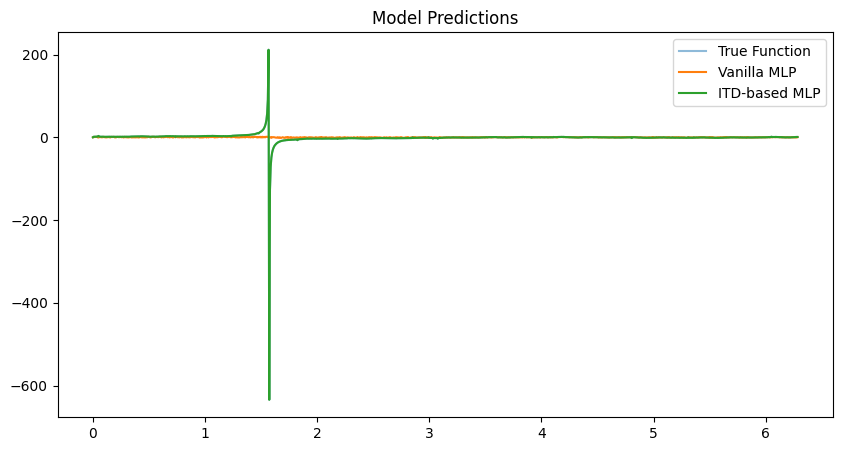

In [17]:

print("\nTraining Vanilla MLP")
vanilla_losses = train(vanilla_mlp, X_train, y_train)

print("\nTraining ITD-based MLP")
itd_losses = train(itd_mlp, X_train, y_train)

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(vanilla_losses, label="Vanilla MLP Loss")
plt.plot(itd_losses, label="ITD-based MLP Loss")
plt.legend()
plt.title("Training Loss Comparison")
plt.show()

# Plot predictions (squeeze out batch and feature dimensions for plotting)
with torch.no_grad():
    vanilla_pred = vanilla_mlp(X_train).squeeze(0).cpu().numpy()  # shape: (1000, 1)
    itd_pred = itd_mlp(X_train).squeeze(0).cpu().numpy()          # shape: (1000, 1)

plt.figure(figsize=(10, 5))
plt.plot(X, y, label="True Function", alpha=0.5)
plt.plot(X, vanilla_pred, label="Vanilla MLP")
plt.plot(X, itd_pred, label="ITD-based MLP")
plt.legend()
plt.title("Model Predictions")
plt.show()



In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Data Generation & Splitting
# -----------------------------
def generate_data(n_samples=500):
    X = np.linspace(0, 2 * np.pi, n_samples)
    # Slow-moving trend
    slow_trend = np.sin(2 * X)
    # Fast oscillations
    fast_oscillations = 0.4 * np.sin(20 * X) + 0.2 * np.sin(30 * X + np.pi / 3)
    # Spikes
    spikes = np.zeros_like(X)
    spike_indices = np.random.choice(n_samples, size=15, replace=False)
    spikes[spike_indices] = np.random.uniform(-2, 2, size=15)
    # Noise
    noise = 0.1 * np.random.randn(n_samples)
    y = slow_trend + fast_oscillations + spikes + noise
    return X.reshape(-1, 1), y.reshape(-1, 1)

def split_data(X, y):
    mid = X.shape[0] // 2
    return X[:mid], y[:mid], X[mid:], y[mid:]

# -----------------------------
# ITD-Linear Layer Definition
# -----------------------------

# -----------------------------
# Training Routine
# -----------------------------
def train(model, X_train, y_train, epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return model

# -----------------------------
# Main: Prepare Data, Train, Evaluate, Plot
# -----------------------------
# Generate and split data
X, y = generate_data(n_samples=500)
X_train_np, y_train_np, X_test_np, y_test_np = split_data(X, y)

# Convert to tensors and add batch dimension (batch size = 1)
X_train = torch.tensor(X_train_np, dtype=torch.float32).unsqueeze(0)  # (1, L_train, 1)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(0)
X_test = torch.tensor(X_test_np, dtype=torch.float32).unsqueeze(0)    # (1, L_test, 1)
y_test = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(0)

input_length = X_train.shape[1]

# Initialize and train ITDMLP
hidden_dim = 50
itd_mlp = ITDMLP(input_length=input_length, hidden_dim=hidden_dim, output_length=input_length)


Epoch 0, Loss: 2.4472
Epoch 20, Loss: 0.1847
Epoch 40, Loss: 0.0191
Epoch 60, Loss: 0.0028
Epoch 80, Loss: 0.0003
Epoch 100, Loss: 0.0000
Epoch 120, Loss: 0.0000
Epoch 140, Loss: 0.0000
Epoch 160, Loss: 0.0000
Epoch 180, Loss: 0.0000
Epoch 200, Loss: 0.0000


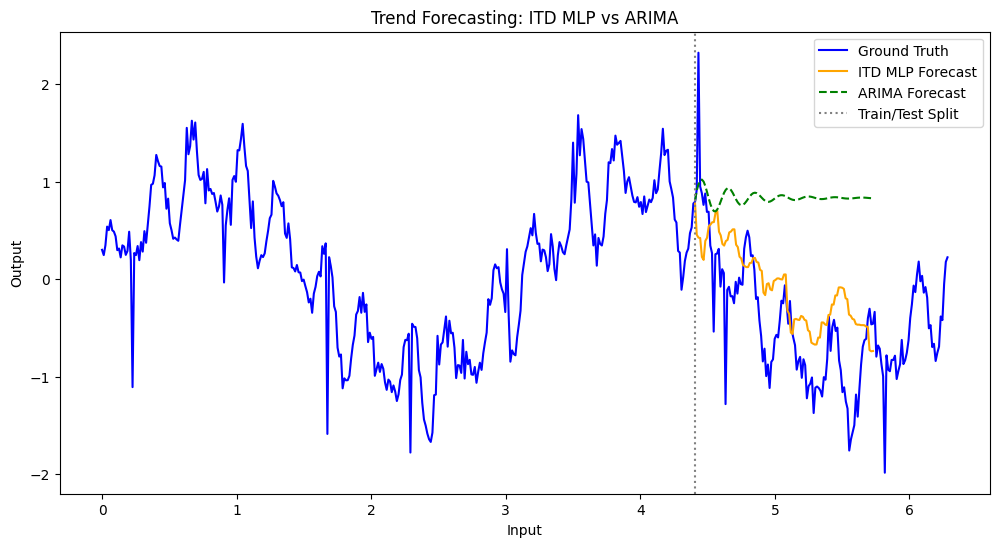

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# -----------------------------
# Forecasting with ITD MLP
# -----------------------------
def itd_forecast(model, X_seed, forecast_steps):
    """
    Forecast future data points using the trained ITD MLP.
    """
    model.eval()
    predictions = []
    current_input = X_seed.clone()

    with torch.no_grad():
        for _ in range(forecast_steps):
            output = model(current_input)
            next_value = output[:, -1, :].unsqueeze(1)  # Get last predicted point
            predictions.append(next_value.squeeze().item())
            # Append the next value to current input for next prediction
            current_input = torch.cat((current_input[:, 1:, :], next_value), dim=1)

    return predictions

# -----------------------------
# ARIMA Forecasting
# -----------------------------
def arima_forecast(y_train_np, forecast_steps, order=(3, 1, 2)):
    """
    Apply ARIMA for trend forecasting.
    """
    model = ARIMA(y_train_np.squeeze(), order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=forecast_steps)
    return forecast

# -----------------------------
# Demo: Trend Forecasting Comparison
# -----------------------------
total_samples = X_train_forecast.shape[1]

# Parameters
forecast_steps = int(total_samples * 0.3)   # Number of future points to predict

# -----------------------------
# Data Preparation
# -----------------------------
# Use existing data
total_samples = y.shape[0]
train_samples = int(total_samples * 0.7)  # 70% training

# Training data
X_train_forecast = torch.tensor(X[:train_samples], dtype=torch.float32).unsqueeze(0)
y_train_forecast = torch.tensor(y[:train_samples], dtype=torch.float32).unsqueeze(0)

# Testing/True future data
X_future = X[train_samples:]
y_future = y[train_samples:]

# -----------------------------
# Train ITD MLP on Partial Data
# -----------------------------
input_length = X_train_forecast.shape[1]
hidden_dim =3

# Initialize ITD MLP
itd_mlp_forecast = ITDMLP(input_length=input_length, hidden_dim=hidden_dim, output_length=input_length)

# Training function (reusing from earlier)
itd_mlp_forecast = train(itd_mlp_forecast, X_train_forecast, y_train_forecast, epochs=220, lr=0.001)

# -----------------------------
# ITD MLP Forecast
# -----------------------------
itd_forecasted = itd_forecast(itd_mlp_forecast, X_train_forecast, forecast_steps)

# -----------------------------
# ARIMA Forecast
# -----------------------------
y_train_np = y[:train_samples].squeeze()
arima_forecasted = arima_forecast(y_train_np, forecast_steps)

# -----------------------------
# Plot Comparison
# -----------------------------
# Prepare X-axis for forecasted steps
X_forecast = np.linspace(X[train_samples], X[train_samples] + forecast_steps * (X[1] - X[0]), forecast_steps)

plt.figure(figsize=(12, 6))
# Ground truth (all data)
plt.plot(X.squeeze(), y.squeeze(), label='Ground Truth', color='blue')
# ITD MLP forecast
plt.plot(X_forecast, itd_forecasted, label='ITD MLP Forecast', color='orange')
# ARIMA forecast
plt.plot(X_forecast, arima_forecasted, label='ARIMA Forecast', color='green', linestyle='--')

# Highlight the training region
plt.axvline(x=X[train_samples], color='grey', linestyle=':', label='Train/Test Split')

plt.title('Trend Forecasting: ITD MLP vs ARIMA')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()


In [ ]:
class CharRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.GELU()

    def forward(self, x, h_prev):
        h_candidate = self.i2h(x) + self.h2h(h_prev)
        h_new = self.activation(h_candidate)
        return h_new

class CharRNNModel(nn.Module):
    def __init__(self, seq_len, vocab_size, embed_dim=128, hidden_size=256, num_layers=2, placeholder_idx=None):
        super().__init__()
        self.activation = nn.GELU()
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.placeholder_idx = placeholder_idx

        self.cells_left = nn.ModuleList([
            CharRNNCell(embed_dim if i == 0 else hidden_size, hidden_size) for i in range(num_layers)
        ])

    def forward(self, x, past_kv=None):
        batch_size = x.shape[0]
        hidden_state = [torch.zeros(batch_size, self.hidden_size, device=x.device)
                            for _ in range(self.num_layers)]

        outputs = []
        new_hidden_state = []

        for t in range(x.shape[1]):
            input_t = x[:, t, :]
            new_hidden = []

            for idx in range(len(self.cells_left)):
                cell_left = self.cells_left[idx]
                h_prev = hidden_state[idx]  # Assuming hidden_state has same length

                h_new = cell_left(input_t, h_prev)


                new_hidden.append(h_new)
                input_t = h_new


            hidden_state = new_hidden
            outputs.append(input_t)

        outputs = torch.stack(outputs, dim=1)  # (batch_size, seq_len, hidden_size)

        # ✅ In training, return None for cache. In eval, return consistent 3D cache.
        return outputs

Epoch 0, Loss: 0.6076
Epoch 20, Loss: 0.0396
Epoch 40, Loss: 0.0203
Epoch 60, Loss: 0.0175
Epoch 80, Loss: 0.0159
Epoch 100, Loss: 0.0148
Epoch 120, Loss: 0.0140
Epoch 140, Loss: 0.0133
Epoch 160, Loss: 0.0127
Epoch 180, Loss: 0.0121


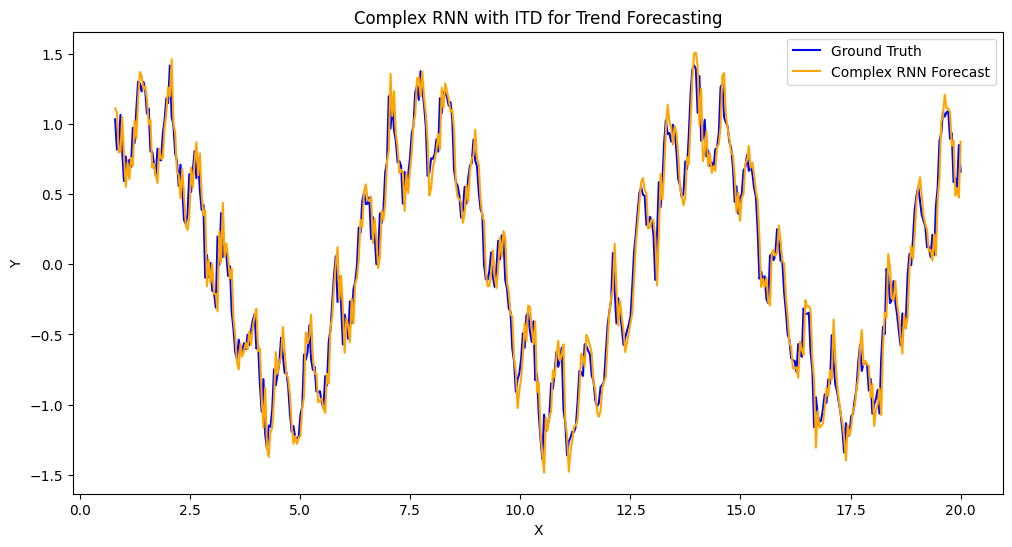

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.GELU()

    def forward(self, x, h_prev):
        h_candidate = self.i2h(x) + self.h2h(h_prev)
        h_new = self.activation(h_candidate)
        return h_new


class RNNForecasterWithITD(nn.Module):
    def __init__(self, seq_len=20, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Apply ITD before feeding into the RNN
        self.itd_layer = ITD_Linear(input_length=seq_len, input_dim=1, output_dim=hidden_size)  # Adjust input_length based on sequence

        self.cells = nn.ModuleList([
            RNNCell(hidden_size, hidden_size) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Apply ITD over the entire sequence
        itd_output = self.itd_layer(x)  # (batch, hidden_size, seq_len)

        # Reshape for RNN: (batch, seq_len, hidden_size)
        itd_output = itd_output.permute(0, 2, 1)

        batch_size, seq_len, _ = itd_output.shape
        hidden_states = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        outputs = []

        for t in range(seq_len):
            input_t = itd_output[:, t, :]  # Pass ITD output at time t

            for idx, cell in enumerate(self.cells):
                h_prev = hidden_states[idx]
                h_new = cell(input_t, h_prev)
                hidden_states[idx] = h_new
                input_t = h_new  # Pass to next layer

            output_t = self.fc_out(input_t)
            outputs.append(output_t)

        outputs = torch.stack(outputs, dim=1)  # (batch, seq_len, output_size)
        return outputs

# -----------------------------
# Quick Test of the Model
# -----------------------------
# Simulated data
X = np.linspace(0, 20, 500)
y = np.sin(X) + 0.3 * np.sin(10 * X) + 0.1 * np.random.randn(500)

# Prepare data for RNN
seq_len = 20
X_seq = []
y_seq = []

for i in range(len(X) - seq_len):
    X_seq.append(y[i:i+seq_len])
    y_seq.append(y[i+1:i+seq_len+1])  # Shifted for prediction

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Convert to tensors
X_tensor = torch.tensor(X_seq, dtype=torch.float32).unsqueeze(-1)
y_tensor = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(-1)

# Initialize and train RNN
rnn_forecaster = RNNForecasterWithITD(seq_len=seq_len,input_size=1, hidden_size=64, num_layers=2, output_size=1)
optimizer = optim.Adam(rnn_forecaster.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
for epoch in range(200):
    rnn_forecaster.train()
    optimizer.zero_grad()
    output = rnn_forecaster(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# -----------------------------
# Forecast and Plot
# -----------------------------
rnn_forecaster.eval()
with torch.no_grad():
    rnn_pred = rnn_forecaster(X_tensor).squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.plot(X[seq_len:], y[seq_len:], label='Ground Truth', color='blue')
plt.plot(X[seq_len:], rnn_pred[:, -1], label='Complex RNN Forecast', color='orange')
plt.title('Complex RNN with ITD for Trend Forecasting')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


Epoch 0, Loss: 0.4750
Epoch 20, Loss: 0.0369
Epoch 40, Loss: 0.0316
Epoch 60, Loss: 0.0281
Epoch 80, Loss: 0.0272
Epoch 100, Loss: 0.0267
Epoch 120, Loss: 0.0263
Epoch 140, Loss: 0.0260
Epoch 160, Loss: 0.0257
Epoch 180, Loss: 0.0254


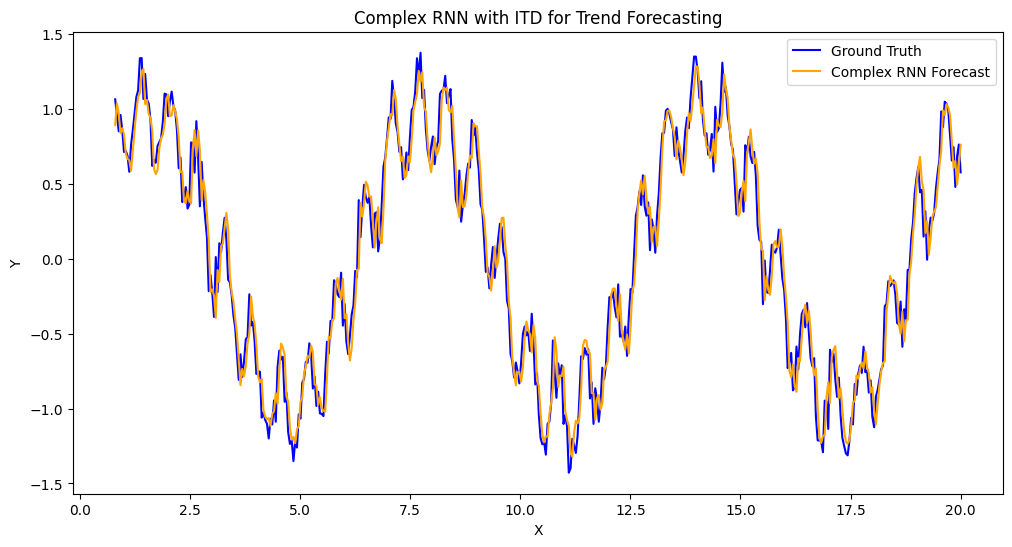

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.GELU()

    def forward(self, x, h_prev):
        h_candidate = self.i2h(x) + self.h2h(h_prev)
        h_new = self.activation(h_candidate)
        return h_new


class VanillaRNNForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cells = nn.ModuleList([
            RNNCell(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Directly use raw input x: (batch, seq_len, input_size)
        batch_size, seq_len, _ = x.shape
        hidden_states = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        outputs = []

        for t in range(seq_len):
            input_t = x[:, t, :]  # Direct input at time t

            for idx, cell in enumerate(self.cells):
                h_prev = hidden_states[idx]
                h_new = cell(input_t, h_prev)
                hidden_states[idx] = h_new
                input_t = h_new  # Pass to next layer

            output_t = self.fc_out(input_t)
            outputs.append(output_t)

        outputs = torch.stack(outputs, dim=1)  # (batch, seq_len, output_size)
        return outputs


# -----------------------------
# Quick Test of the Model
# -----------------------------
# Simulated data
X = np.linspace(0, 20, 500)
y = np.sin(X) + 0.3 * np.sin(10 * X) + 0.1 * np.random.randn(500)

# Prepare data for RNN
seq_len = 20
X_seq = []
y_seq = []

for i in range(len(X) - seq_len):
    X_seq.append(y[i:i+seq_len])
    y_seq.append(y[i+1:i+seq_len+1])  # Shifted for prediction

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Convert to tensors
X_tensor = torch.tensor(X_seq, dtype=torch.float32).unsqueeze(-1)
y_tensor = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(-1)

# Initialize and train RNN
rnn_forecaster = VanillaRNNForecaster(input_size=1, hidden_size=64, num_layers=2,  output_size=1)
optimizer = optim.Adam(rnn_forecaster.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
for epoch in range(200):
    rnn_forecaster.train()
    optimizer.zero_grad()
    output = rnn_forecaster(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# -----------------------------
# Forecast and Plot
# -----------------------------
rnn_forecaster.eval()
with torch.no_grad():
    rnn_pred = rnn_forecaster(X_tensor).squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.plot(X[seq_len:], y[seq_len:], label='Ground Truth', color='blue')
plt.plot(X[seq_len:], rnn_pred[:, -1], label='Complex RNN Forecast', color='orange')
plt.title('Complex RNN with ITD for Trend Forecasting')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


Epoch 0, Loss: 0.5635
Epoch 20, Loss: 0.1737
Epoch 40, Loss: 0.0990
Epoch 60, Loss: 0.0336
Epoch 80, Loss: 0.0251
Epoch 100, Loss: 0.0236
Epoch 120, Loss: 0.0229
Epoch 140, Loss: 0.0224
Epoch 160, Loss: 0.0220
Epoch 180, Loss: 0.0218
Epoch 0, Loss: 0.5680
Epoch 20, Loss: 0.3547
Epoch 40, Loss: 0.0927
Epoch 60, Loss: 0.0297
Epoch 80, Loss: 0.0146
Epoch 100, Loss: 0.0104
Epoch 120, Loss: 0.0085
Epoch 140, Loss: 0.0078
Epoch 160, Loss: 0.0073
Epoch 180, Loss: 0.0072


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


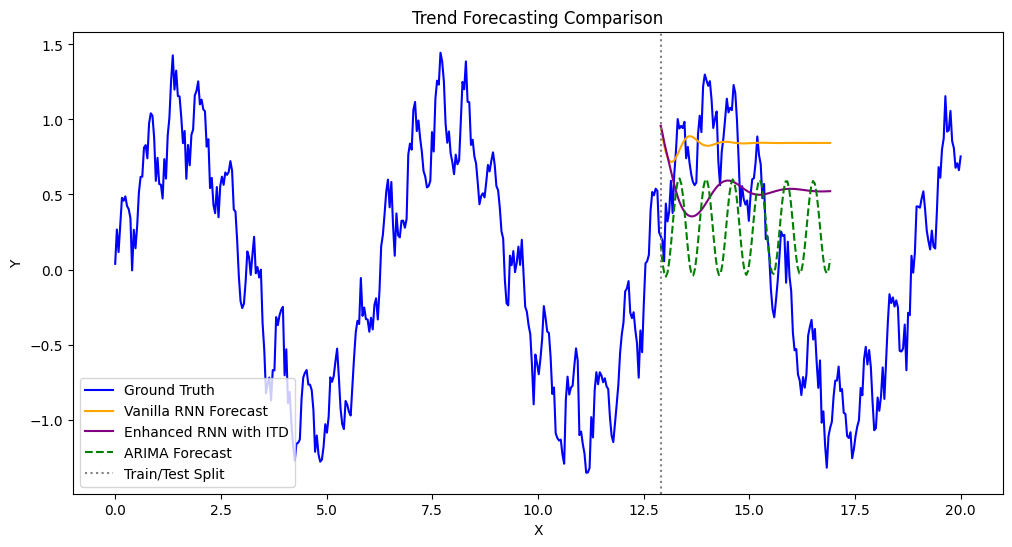

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# -----------------------------
# Forecasting Functions
# -----------------------------
def arima_forecast(y_train_np, forecast_steps, order=(3, 1, 2)):
    model = ARIMA(y_train_np.squeeze(), order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=forecast_steps)
    return forecast
def rnn_forecast(model, X_seed, forecast_steps):
    """
    Forecast future data points using the trained RNN.
    """
    model.eval()
    predictions = []
    current_input = X_seed.clone()

    with torch.no_grad():
        for _ in range(forecast_steps):
            output = model(current_input)  # Output shape: (batch_size, seq_len, output_size)
            next_value = output[:, -1, :]  # Take the last time step

            # Select the first element in the batch to avoid shape issues
            predictions.append(next_value[0].item())

            # Update current input for next step
            next_value_unsqueezed = next_value.unsqueeze(1)  # Shape: (batch_size, 1, output_size)
            current_input = torch.cat((current_input[:, 1:, :], next_value_unsqueezed), dim=1)

    return predictions

# -----------------------------
# Data Preparation
# -----------------------------
X = np.linspace(0, 20, 500)
y = np.sin(X) + 0.3 * np.sin(10 * X) + 0.1 * np.random.randn(500)

seq_len = 40
X_seq = []
y_seq = []

for i in range(len(X) - seq_len):
    X_seq.append(y[i:i+seq_len])
    y_seq.append(y[i+1:i+seq_len+1])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

X_tensor = torch.tensor(X_seq, dtype=torch.float32).unsqueeze(-1)
y_tensor = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(-1)

# -----------------------------
# Forecasting Comparison
# -----------------------------
forecast_steps = 100
train_samples = int(len(X_tensor) * 0.7)

X_train = X_tensor[:train_samples]
y_train = y_tensor[:train_samples]

X_future = X[train_samples:]
y_future = y[train_samples:]

# Initialize Models
vanilla_rnn = VanillaRNNForecaster(input_size=1, hidden_size=64, num_layers=10, output_size=1)
enhanced_rnn = RNNForecasterWithITD(seq_len,input_size=1, hidden_size=64, num_layers=10, output_size=1)

# Training Function
def train_rnn(model, X_train, y_train, epochs=200, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return model

# Train Models
vanilla_rnn = train_rnn(vanilla_rnn, X_train, y_train)
enhanced_rnn = train_rnn(enhanced_rnn, X_train, y_train)

# Forecasting
vanilla_forecasted = rnn_forecast(vanilla_rnn, X_train, forecast_steps)
enhanced_forecasted = rnn_forecast(enhanced_rnn, X_train, forecast_steps)
y_train_np = y[:train_samples].squeeze()
arima_forecasted = arima_forecast(y_train_np, forecast_steps)

# -----------------------------
# Plot Comparison
# -----------------------------
X_forecast = np.linspace(X[train_samples], X[train_samples] + forecast_steps * (X[1] - X[0]), forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(X, y, label='Ground Truth', color='blue')
plt.plot(X_forecast, vanilla_forecasted, label='Vanilla RNN Forecast', color='orange')
plt.plot(X_forecast, enhanced_forecasted, label='Enhanced RNN with ITD', color='purple')
plt.plot(X_forecast, arima_forecasted, label='ARIMA Forecast', color='green', linestyle='--')
plt.axvline(x=X[train_samples], color='grey', linestyle=':', label='Train/Test Split')
plt.title('Trend Forecasting Comparison')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [37]:
def rnn_forecast(model, X_seed, forecast_steps):
    """
    Forecast future data points using the trained RNN.
    """
    model.eval()
    predictions = []
    current_input = X_seed.clone()

    with torch.no_grad():
        for _ in range(forecast_steps):
            output = model(current_input)  # Output shape: (batch_size, seq_len, output_size)
            next_value = output[:, -1, :]  # Take the last time step

            # Select the first element in the batch to avoid shape issues
            predictions.append(next_value[0].item())

            # Update current input for next step
            next_value_unsqueezed = next_value.unsqueeze(1)  # Shape: (batch_size, 1, output_size)
            current_input = torch.cat((current_input[:, 1:, :], next_value_unsqueezed), dim=1)

    return predictions


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


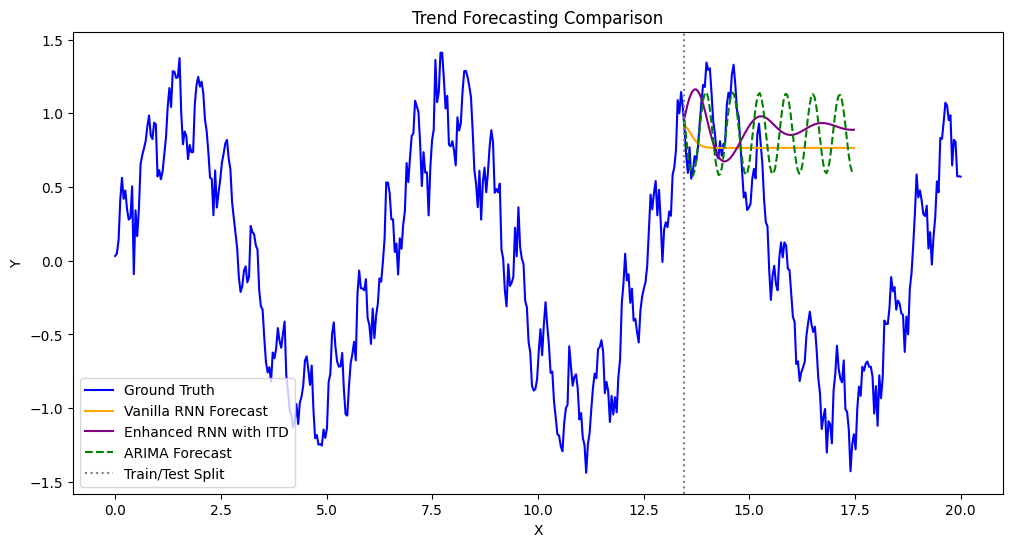

In [38]:

vanilla_forecasted = rnn_forecast(vanilla_rnn, X_train, forecast_steps)
enhanced_forecasted = rnn_forecast(enhanced_rnn, X_train, forecast_steps)
y_train_np = y[:train_samples].squeeze()
arima_forecasted = arima_forecast(y_train_np, forecast_steps)

# -----------------------------
# Plot Comparison
# -----------------------------
X_forecast = np.linspace(X[train_samples], X[train_samples] + forecast_steps * (X[1] - X[0]), forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(X, y, label='Ground Truth', color='blue')
plt.plot(X_forecast, vanilla_forecasted, label='Vanilla RNN Forecast', color='orange')
plt.plot(X_forecast, enhanced_forecasted, label='Enhanced RNN with ITD', color='purple')
plt.plot(X_forecast, arima_forecasted, label='ARIMA Forecast', color='green', linestyle='--')
plt.axvline(x=X[train_samples], color='grey', linestyle=':', label='Train/Test Split')
plt.title('Trend Forecasting Comparison')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()
